# Deterministic bottleneck

This notebook gives some examples related to the Deterministic Information Bottleneck (DIB; [Strouse and Schwab, Neural Computation 2017](https://arxiv.org/abs/1604.00268)), and its comparison to the regular IB. In particular, we will work with distributions like those used for Figure 2 in the DIB paper.

In [1]:
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib
import matplotlib.pyplot as plt

from embo import InformationBottleneck

plt.style.use('style.mplstyle')
figsize = plt.rcParams['figure.figsize']

rng = np.random.default_rng()

We start by defining the class of probability distributions we will work with in this example. From Strouse and Schwab 2016, section 4:

*To generate the $p(x,y)$, we first sampled $p(x)$ from a symmetric Dirichlet distribution with concentration parameter $\alpha_x$ (so $p(x)\sim\text{Dir}[\alpha_x]$), and then sampled each row of $p(y|x)$ from another symmetric Dirichlet distribution with concentration parameter $\alpha_y^{(i)}$ (so $p(y|x_i)\sim\text{Dir}[\alpha_y^{(i)}]$). In the experiments shown here, we set $\alpha_x$ to 1000, so that each $x_i$ was approximately equally likely, and we set $\alpha_y^{(i)}$ to be equally spaced logarithmically between $10^{−1.3}$ and $10^{1.3}$, in order to provide a range of informativeness in the conditionals. We set the cardinalities of $X$ and $Y$ to $|X|= 256$ and $|Y|= 32$.*

Cross-referencing the [code associated to the paper](https://github.com/djstrouse/information-bottleneck), this can be implemented as follows.

In [2]:
def sample_pxy(alpha_x=1000, alpha_y_log_min=-1.3, alpha_y_log_max=1.3, X=256, Y=32):
    px = rng.dirichlet(np.full(X, alpha_x))
    alpha_y = np.logspace(alpha_y_log_min, alpha_y_log_max, X)
    pyx_c = np.zeros((Y,X))
    for xi, ay in enumerate(alpha_y):
        pyx_c[:,xi] = rng.dirichlet(np.full(Y, ay))
    pyx = pyx_c * px[np.newaxis,:]
    return pyx.T

## Basic DIB example

We can sample one distribution from the class described above and visualize it. Note that we set $X=128$ instead of 256. Looking closely at Figure 2 in the paper suggests that this was the value actually used for the parameter, because $H(X)\simeq 7$, and setting $\alpha_x=1000$ effectively corresponds to choosing $p(x)$ close to uniform, so one can expect $H(X)\simeq\log |X|$.

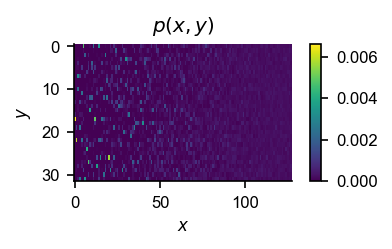

In [3]:
pxy = sample_pxy(X=128)
fig, ax = plt.subplots()
h = ax.imshow(pxy.T, aspect='auto', interpolation='none')
fig.colorbar(h)
ax.set_title('$p(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Now we compute and plot the IB and the DIB for this distribution, and plot them in both the $H(M), I(M:Y)$ plane and the $I(M:X), I(M:Y)$ plane. In other words, we look at the results of the optimization in both the "DIB plane" and the regular "IB plane". Because we want to look at the results in both planes, we set `ensure_monotonic_bound=False` to make sure that the solutions corrisponding to all $\beta$ values are displayed in our plots.

We compute the IB and the DIB in separate cells of the notebook to better display the time took by each computation.

In [4]:
alphas = [0,1]
ib = {
    alpha : InformationBottleneck(
        pxy=pxy,
        alpha=alpha,
        maxbeta=10 if alpha==0 else 100,
        numbeta=50,
        processes=4,
        ensure_monotonic_bound=False) for alpha in alphas
}

In [5]:
%time _ = ib[0].get_bottleneck()

CPU times: user 257 ms, sys: 60.5 ms, total: 318 ms
Wall time: 18.8 s


In [6]:
%time _ = ib[1].get_bottleneck()

CPU times: user 196 ms, sys: 23.7 ms, total: 219 ms
Wall time: 31 s


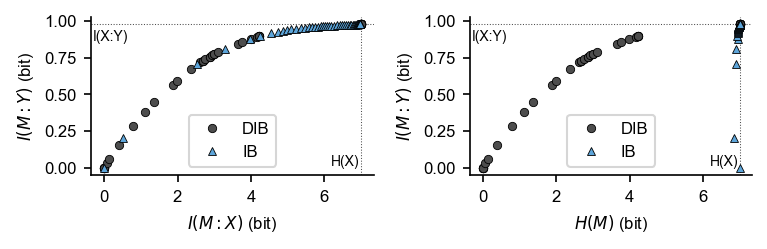

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=np.array((2,1))*figsize, sharey='col')

for alpha in [0, 1]:
    label = 'IB' if alpha==1 else 'DIB'
    marker = '^' if alpha==1 else 'o'
    markersize = 4
    # plot in IB plane
    ax[0].plot(ib[alpha].i_x, ib[alpha].i_y, label=label, marker=marker, linestyle='', markersize=markersize)
    # plot in DIB plane
    ax[1].plot(ib[alpha].h_m, ib[alpha].i_y, label=label, marker=marker, linestyle='', markersize=markersize)

ax[0].set_xlabel('$I(M:X)$ (bit)')
ax[1].set_xlabel('$H(M)$ (bit)')

for a in ax:
    a.axhline(ib[0].mixy, zorder=-5, linewidth=.5, linestyle=":")
    a.axvline(ib[0].hx, zorder=-5, linewidth=.5, linestyle=":")
    a.set_ylabel('$I(M:Y)$ (bit)');
    a.set_yticks(np.linspace(0,1,5))
    pad = 0.04
    a.text(a.get_xlim()[0]+pad, ib[0].mixy-pad, 'I(X:Y)', horizontalalignment='left', verticalalignment='top', fontsize='small')
    a.text(ib[0].hx-pad, a.get_ylim()[0]+pad, 'H(X)', horizontalalignment='right', verticalalignment='bottom', fontsize='small')
    a.legend()

As expected, the figure above roughly reproduces figure 2 in the DIB paper: in the IB plane (left panel) the DIB behaves very similarly to the IB, while in the DIB plane the DIB clearly does better. We also note that the DIB takes less time to run than the IB.

With reference to the other IB/DIB comparisons performed in the DIB paper, we note here that for both DIB and IB we are initializing the candidate distribution close to a "multi-cluster" encoder for which most of the conditional probability mass of $p(m|x_j)$ is assigned to $m_j$ (see discussion of the initialization in the DIB paper for more details).

## Generalized Information Bottleneck demonstration
We will now show the Generalized Information Bottleneck at work. We will make a plot similar to the above, except for a range of values of $\alpha$, which we will allow to vary continuously between 0 and 1. This will show how the algorithm smoothly interpolates between DIB and IB. For computational convenience, in this demonstration we will work with random variables of smaller cardinality.

In [8]:
%%time
# define RVs
pxy_small = sample_pxy(X=8, Y=5)

alphas = np.linspace(0,1,7)
gib = {
    alpha : InformationBottleneck(
        pxy=pxy_small,
        alpha=alpha,
        maxbeta=15,
        numbeta=100,
        processes=1,
        ensure_monotonic_bound=False) for alpha in alphas
}

# compute GIB
for alpha in alphas:
    gib[alpha].get_bottleneck()

CPU times: user 1.43 s, sys: 552 ms, total: 1.98 s
Wall time: 9.91 s


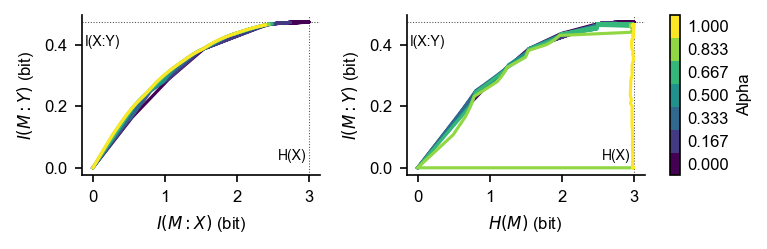

In [9]:
# make plots
fig, ax = plt.subplots(ncols=2, figsize=np.array((2,1))*figsize, sharey='col')
cm_lg = plt.get_cmap('viridis',len(alphas))

for k, alpha in enumerate(alphas):
    label = alpha
    marker = ''
    linestyle = '-'
    markersize = 4
    linewidth = 1.5
    color = cm_lg(k/(len(alphas)-1))
    # plot in IB plane
    ax[0].plot(
        gib[alpha].i_x, gib[alpha].i_y,
        label=label, marker=marker, linestyle=linestyle, markersize=markersize, color=color, linewidth=linewidth)
    # plot in DIB plane
    ax[1].plot(
        gib[alpha].h_m, gib[alpha].i_y,
        label=label, marker=marker, linestyle=linestyle, markersize=markersize, color=color, linewidth=linewidth)

ax[0].set_xlabel('$I(M:X)$ (bit)')
ax[1].set_xlabel('$H(M)$ (bit)')

for a in ax:
    a.axhline(gib[0].mixy, zorder=-5, linewidth=.5, linestyle=":")
    a.axvline(gib[0].hx, zorder=-5, linewidth=.5, linestyle=":")
    a.set_ylabel('$I(M:Y)$ (bit)');
    pad = 0.04
    a.text(a.get_xlim()[0]+pad, gib[0].mixy-pad, 'I(X:Y)', horizontalalignment='left', verticalalignment='top', fontsize='small')
    a.text(gib[0].hx-pad, a.get_ylim()[0]+pad, 'H(X)', horizontalalignment='right', verticalalignment='bottom', fontsize='small')

a_delta = alphas[1]-alphas[0]
cbar = plt.colorbar(
    matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(
            vmin=alphas.min()-a_delta/2, vmax=alphas.max()+a_delta/2), cmap=cm_lg),
    ax=ax, ticks=alphas, location='right', aspect=50)
cbar.ax.tick_params(size=0)
cbar.set_label("Alpha")

In the plots above, remember that $\alpha=0$ is the Deterministic Information Bottleneck and $\alpha=1$ is the regular Information Bottleneck.

We note that even very small deviations from $\alpha=1$ are sufficient to induce the GIB to behave closely to the DIB.